# Working ipynb for explainability in machine learning 

- main goal is to delineate model explainability between Shap, Lime and GAM
- This will act as a shell file on the Austrailian Credit Approval Data until Cap One data is readily available

## Model Building

Imports. Clean up later

In [1]:
from __future__ import print_function
from helpful_util import *
from heaton_utils import *

#import seaborn as sns
#import pandas_profiling
#from pylab import rcParams
#import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

import sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#!pip install livelossplot
from livelossplot import PlotLossesKeras
from tensorflow.python.client import device_lib
from keras.losses import binary_crossentropy

import os
import sys
import glob
#pip install counter
import pickle

import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.utils import layer_utils
from keras import backend as K
from keras.engine.topology import get_source_inputs
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.optimizers import SGD, adam, adamax, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, ReLU, ELU
from keras.losses import binary_crossentropy
from keras.utils import multi_gpu_model
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import multilayer_perceptron
import xgboost
import pandas_profiling
from pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 7,7  #Adjust plot size

device_lib.list_local_devices(
)  #See available devices. If Running a Keras model, session to GPU

Using TensorFlow backend.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1347116309677123457, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6590074061
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5179245661928862975
 physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 6700198133
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 964565294967557766
 physical_device_desc: "device: 1, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1"]

In [83]:
#files, main_dir = list_dir()
#main_dir
#list_dir()[1] #List contents of working Dir

#Clean Data
#Used for Australian Credit Data
#df = load_data(path='data', drop_outliers= False) #Only remove outliers on non-discrete features


#Used initially for UCI data
#df = load_data_UCI(clean=True,
#                   down_sample=False,
#                   up_sample=False,
#                   get_dummies=False)

In [6]:
pandas_profiling.ProfileReport(load_data_UCI(clean=True,
                   down_sample=False,
                   up_sample=False,
                   get_dummies=False)) #Neat tool for quick EDA #Toggle is interactive within jupyter nb

Number of variables,22
Number of observations,30162
Total Missing (%),0.0%
Total size in memory,4.8 MiB
Average record size in memory,168.0 B
Numeric,9
Categorical,8
Boolean,4
Date,0
Text (Unique),0
Rejected,1


In [2]:
#g = sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")

#X_train, X_test, y_train, y_test = split_data(
#    df=df,
#    keras=False,  #Use binary vector for response, no OHE
#    testSize=0.3,
#    randomState=123)


#Cleaning data per the Lime docs. The way I did it initially gave nonsensical results because of the category mapping
#We need to first encode the cat feaures and then one hot encode them using sklearn.preprocessing


feature_names = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status","Occupation", 
                 "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss","Hours per week", "Country"]

data = np.genfromtxt('data\\adult.data', delimiter=', ', dtype=str) #read in data file
#Let's downsample this
neg_target = data[data[:,14] == '<=50K']
pos_target = data[data[:,14] != '<=50K']
neg_target = neg_target[:7481]
data = np.concatenate((pos_target, neg_target))

y = data[:,14] #response var
le= sklearn.preprocessing.LabelEncoder() #instantiate label encoder
le.fit(y) #fit label encoder to response
y = le.transform(y) #encode response
class_names = le.classes_ #get class names of response
data = data[:,:-1] #Get all Independent Vars

categorical_features = [1,3,5, 6,7,8,9,13] #Get Nominal / Ordinal / etc..

categorical_names = {}
for feature in categorical_features:
    le = sklearn.preprocessing.LabelEncoder() #instantiate label encoder
    le.fit(data[:, feature]) #fit label encoder to categorical features
    data[:, feature] = le.transform(data[:, feature]) #transform categorical features
    categorical_names[feature] = le.classes_ #get categorical feature class names and append to dict

X = data.astype(float) 
encoder = sklearn.preprocessing.OneHotEncoder(categorical_features=categorical_features) #instantiate OHE

np.random.seed(1)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.80, stratify = y) #split data

encoder.fit(data) #OHE Categorical Columns
encoded_train = encoder.transform(X_train) #Encode Training Set
y_train_keras = y_train



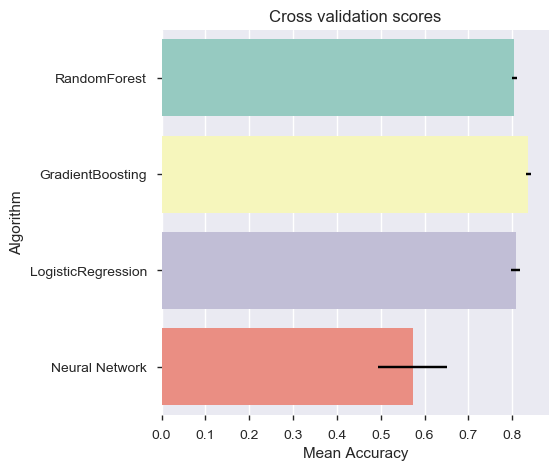

In [10]:
rcParams['figure.figsize'] = 5, 5  #Adjust plot size

# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5)

#Run Kfold CrossVal on base classifiers

random_state = 1
classifiers = []
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))


cv_results = []
for classifier in classifiers:
    cv_results.append(
        cross_val_score(classifier,
                        encoded_train,
                        y=y_train,
                        scoring="accuracy",
                        cv=kfold,
                        n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({
    "CrossValMeans":
    cv_means,
    "CrossValerrors":
    cv_std,
    "Algorithm": ["RandomForest", "GradientBoosting", "LogisticRegression", "Neural Network"]
})

g = sns.barplot("CrossValMeans",
                "Algorithm",
                data=cv_res,
                palette="Set3",
                orient="h",
                **{'xerr': cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [11]:
#Grid Search parameter space.
#Cut back on this due to experimentation and compute time

# RFC Parameters tunning
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {
    "n_estimators": [150,250]
    #"max_features": [1, 2, 3, 4, 5, 6, 7, 8,9,10],
    #"bootstrap": [False],
}

gsRFC = GridSearchCV(RFC,
                     param_grid=rf_param_grid,
                     cv=kfold,
                     scoring="accuracy",
                     n_jobs=6,
                     verbose=1)
gsRFC.fit(encoded_train, y_train)

# Gradient boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {
    'n_estimators': [1000,2000]
    #'learning_rate': [.001],
    #'max_depth': [4, 8, 12],
}

gsGBC = GridSearchCV(GBC,
                     param_grid=gb_param_grid,
                     cv=kfold,
                     scoring="accuracy",
                     n_jobs=6,
                     verbose=1)
gsGBC.fit(encoded_train, y_train)

#Sklearn Logit Regression Tuning
LR = LogisticRegression()
LR_param_grid = {'penalty': ['l1', 'l2']}

gsLR = GridSearchCV(LR,
                    param_grid=LR_param_grid,
                    cv=kfold,
                    scoring="accuracy",
                    n_jobs=6,
                    verbose=1)
gsLR.fit(encoded_train, y_train)

ANN = MLPClassifier()

## Search grid for optimal parameters
ann_param_grid = {
    "hidden_layer_sizes": [150,250,500],
    "activation": ['tanh', 'relu'],
    "solver": ['sgd', 'adam'],
    "learning_rate": ['adaptive'],
    

}

gsAnn = GridSearchCV(ANN,
                     param_grid=ann_param_grid,
                     cv=kfold,
                     scoring="accuracy",
                     n_jobs=6,
                     verbose=1)
gsAnn.fit(encoded_train, y_train)

# Best score
print("\033[1mPrinting Best Cross Validation Accuracy.... \033[0m")
print("RF Best Score: {0:.2f} %".format(gsRFC.best_score_ * 100))
print("GBC Best Score: {0:.2f} %".format(gsGBC.best_score_ * 100))
print("Logit Best Score: {0:.2f} %".format(gsLR.best_score_ * 100))
print("MLP Best Score: {0:.2f} %".format(gsAnn.best_score_ * 100))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   17.7s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   17.7s finished


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   33.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   33.5s finished


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.2s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:  3.1min finished


Printing Best Cross Validation Accuracy.... 
RF Best Score: 82.31 %
GBC Best Score: 83.96 %
Logit Best Score: 82.26 %
MLP Best Score: 66.10 %


C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [12]:
#Visualizing hyper params of best models + dumping best models to pkl

print("Model Hyper-Parameters:\n")
print(gsRFC.best_estimator_)
print(gsGBC.best_estimator_)
print(gsLR.best_estimator_)
print(gsAnn.best_estimator_)
import pickle
from sklearn.externals import joblib

print("Serializing Best Models\n")
rf_file = "models\\UCI_Census\\random_forest.pkl"
joblib.dump(gsRFC.best_estimator_, rf_file)

gbc_file = "models\\UCI_Census\\GBC.pkl"
joblib.dump(gsGBC.best_estimator_, gbc_file)

logit_file = "models\\UCI_Census\\Logit.pkl"
joblib.dump(gsLR.best_estimator_, logit_file)

ann_file = "models\\UCI_Census\\SklearnNeuralNet.pkl"
joblib.dump(gsAnn.best_estimator_, ann_file)
#Note - Outliers were removed, but no features were scaled / normalized.

Model Hyper-Parameters:

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, pres

['models\\UCI_Census\\SklearnNeuralNet.pkl']

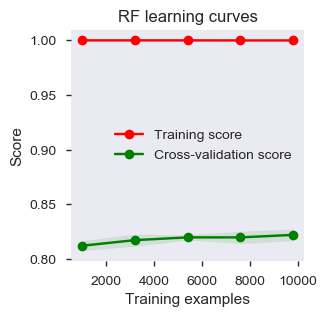

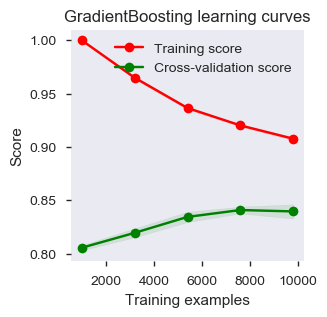

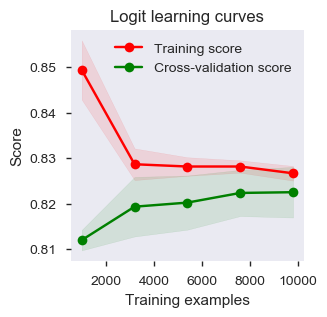

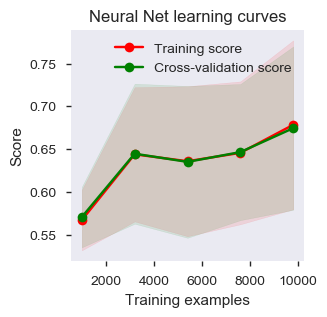

In [13]:
from sklearn.externals import joblib
rcParams['figure.figsize'] = 3, 3  #Adjust plot size
kfold = StratifiedKFold(n_splits=5)
rf_file = "models\\UCI_Census\\random_forest.pkl"
gbc_file = "models\\UCI_Census\\GBC.pkl"
logit_file = "models\\UCI_Census\\Logit.pkl"
ann_file = "models\\UCI_Census\\SklearnNeuralNet.pkl"
#fetch saved models
rfc = joblib.load(rf_file)
gbc = joblib.load(gbc_file)
logit = joblib.load(logit_file)
ann = joblib.load(ann_file)

#Learning Curve. Works better w. more data.
#Visualizes how estimators perform given more data
g = plot_learning_curve(rfc, "RF learning curves", encoded_train, y_train, cv=kfold)
g = plot_learning_curve(gbc,
                        "GradientBoosting learning curves",
                        encoded_train,
                        y_train,
                        cv=kfold)
g = plot_learning_curve(logit,
                        "Logit learning curves",
                        encoded_train,
                        y_train,
                        cv=kfold)
g = plot_learning_curve(ann,
                        "Neural Net learning curves",
                        encoded_train,
                        y_train,
                        cv=kfold)

Printing Test Accuracy.... 
Random Forest: 82.25 %
Gradient Boosting: 84.37 %
Logistic Regression: 81.86 %
Neural Net: 68.12 % 
 

 Random Forest Classification Report...
 
              precision    recall  f1-score   support

           0       0.84      0.79      0.81      1496
           1       0.81      0.85      0.83      1569

    accuracy                           0.82      3065
   macro avg       0.82      0.82      0.82      3065
weighted avg       0.82      0.82      0.82      3065



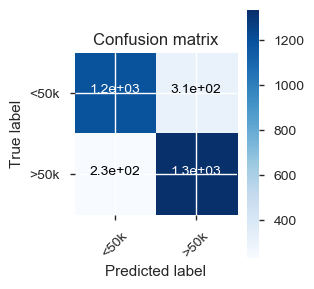

 Gradient Boosting Classification Report...
 
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1496
           1       0.83      0.88      0.85      1569

    accuracy                           0.84      3065
   macro avg       0.85      0.84      0.84      3065
weighted avg       0.84      0.84      0.84      3065



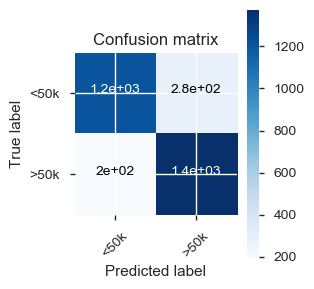

 Logistic Regression Classification Report...
 
              precision    recall  f1-score   support

           0       0.84      0.77      0.81      1496
           1       0.80      0.86      0.83      1569

    accuracy                           0.82      3065
   macro avg       0.82      0.82      0.82      3065
weighted avg       0.82      0.82      0.82      3065



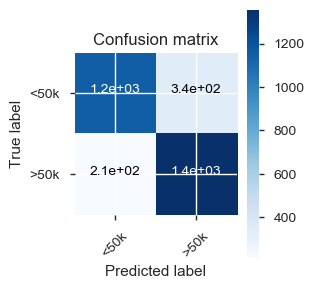

 Neural Network Classification Report...
 
              precision    recall  f1-score   support

           0       0.61      0.95      0.74      1496
           1       0.90      0.42      0.58      1569

    accuracy                           0.68      3065
   macro avg       0.76      0.69      0.66      3065
weighted avg       0.76      0.68      0.66      3065



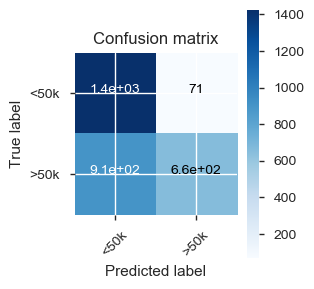

In [17]:
#Some classification Reports and Confusion Matrices
from sklearn.metrics import confusion_matrix, classification_report


class_names = ['<50k', '>50k']

rf_best_score = sklearn.metrics.accuracy_score(y_test, rfc.predict(encoder.transform(X_test)))
gbc_best_score = sklearn.metrics.accuracy_score(y_test, gbc.predict(encoder.transform(X_test)))
lr_best_score = sklearn.metrics.accuracy_score(y_test, logit.predict(encoder.transform(X_test)))
nn_best_score = sklearn.metrics.accuracy_score(y_test, ann.predict(encoder.transform(X_test)))

print("\033[1mPrinting Test Accuracy.... \033[0m")
print("Random Forest: {0:.2f} %".format(rf_best_score * 100))
print("Gradient Boosting: {0:.2f} %".format(gbc_best_score * 100))
print("Logistic Regression: {0:.2f} %".format(lr_best_score * 100))
print("Neural Net: {0:.2f} % \n \n".format(nn_best_score * 100))


rcParams['figure.figsize'] = 3, 3  #Adjust plot size

print("\033[1m Random Forest Classification Report...\n \033[0m")
print(classification_report(y_test, rfc.predict(encoder.transform(X_test))))
cm = confusion_matrix(y_test, rfc.predict(encoder.transform(X_test)))
plot_confusion_matrix(cm, classes=class_names)
plt.show()

print("\033[1m Gradient Boosting Classification Report...\n \033[0m")
print(classification_report(y_test, gbc.predict(encoder.transform(X_test))))
cm = confusion_matrix(y_test, gbc.predict(encoder.transform(X_test)))
plot_confusion_matrix(cm, classes=class_names)
plt.show()

print("\033[1m Logistic Regression Classification Report...\n \033[0m")
print(classification_report(y_test, logit.predict(encoder.transform(X_test))))
cm = confusion_matrix(y_test, logit.predict(encoder.transform(X_test)))
plot_confusion_matrix(cm, classes=class_names)
plt.show()

print("\033[1m Neural Network Classification Report...\n \033[0m")
print(classification_report(y_test, ann.predict(encoder.transform(X_test))))
cm = confusion_matrix(y_test, ann.predict(encoder.transform(X_test)))
plot_confusion_matrix(cm, classes=class_names)
plt.show()


### Deep Learning 
Building an MLP. Using Hyperas for hyperparameter search.



In [15]:
from keras.utils import multi_gpu_model


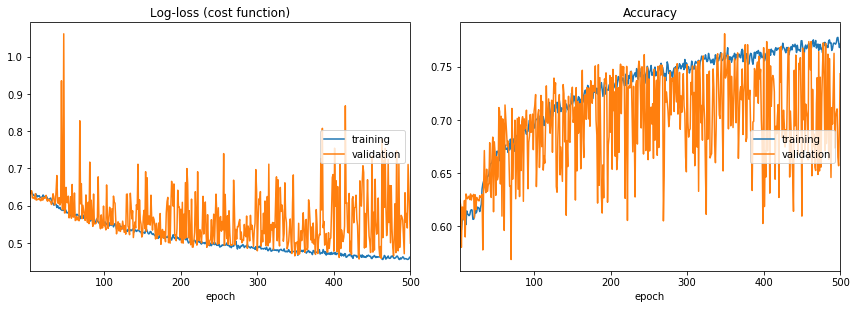

Log-loss (cost function):
training   (min:    0.456, max:    0.778, cur:    0.461)
validation (min:    0.457, max:    1.062, cur:    0.500)

Accuracy:
training   (min:    0.543, max:    0.778, cur:    0.771)
validation (min:    0.566, max:    0.781, cur:    0.743)

Epoch 00500: val_acc did not improve from 0.78100


In [3]:
#Keras Callbacks
#early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
#                                               min_delta=0,
#                                               patience=50,
#                                               verbose=1,
#                                               mode='auto')

y_train_1 = tf.keras.utils.to_categorical(y_train_keras, num_classes=2)


MCP = keras.callbacks.ModelCheckpoint(
    "models\\UCI_Census\\ann_gridsearch.h5",
    monitor='val_acc',
    mode='max',
    verbose=1,
    save_best_only=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              factor=0.1,
                                              patience=10,
                                              min_lr=0.01)  #Annealing.
tensorboard = keras.callbacks.TensorBoard(log_dir="logs\\")

model = Sequential()
model.add(Dense(
    1500, input_shape=(107, )))  #Input shape = input Dim = Number of Ind Vars
model.add(BatchNormalization(momentum = .62))
model.add(Activation('relu'))
model.add(Dropout(.5))

model.add(Dense(500))
#model.add(BatchNormalization(momentum = .62))
model.add(Activation('relu'))
#model.add(Dropout(.25))
model.add(Dense(250))
model.add(Activation('relu'))

model.add(Dense(100))
model.add(Activation('relu'))


model.add(Dense(2))
model.add(Activation('softmax'))

model = multi_gpu_model(model, gpus=2)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                        log_device_placement=True))

history = model.fit(encoded_train.toarray(), y_train_1, batch_size= 500,
                   epochs=500, verbose=2,\
                        validation_split= .2, callbacks=[PlotLossesKeras(), MCP, tensorboard])
sess.close()

In [4]:
path_to_ann = 'models\\UCI_Census\\ann_gridsearch.h5'
model.save(path_to_ann)


In [5]:
model = load_model(path_to_ann)

 Neural Net Classification Report...
 
0.7265905383360522
              precision    recall  f1-score   support

           0       0.83      0.55      0.66      1496
           1       0.68      0.89      0.77      1569

    accuracy                           0.73      3065
   macro avg       0.75      0.72      0.72      3065
weighted avg       0.75      0.73      0.72      3065



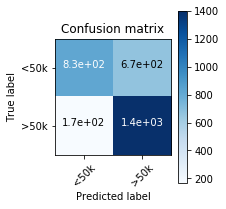

array([[ 827,  669],
       [ 169, 1400]], dtype=int64)

In [6]:
#Some classification Reports and Confusion Matrices
ypred = np.argmax(model.predict(encoder.transform(X_test).toarray()), axis = 1)
ytest = y_test
class_names = ['<50k', '>50k']
rcParams['figure.figsize'] = 3, 3
print("\033[1m Neural Net Classification Report...\n \033[0m")
print(sklearn.metrics.accuracy_score(ytest,ypred))
print(sklearn.metrics.classification_report(ytest, ypred))
cm = sklearn.metrics.confusion_matrix(ytest, ypred)
plot_confusion_matrix(cm, classes=class_names)
plt.show()
cm